# 07. Second Attempt of Training

## 컨셉

- 이전에 만들었던 새로운 generator를 바탕으로
각 방향으로 대칭시킨 데이터를 모두 사용합니다.
- 여기서는 기보에 점수를 연속으로 부여하지는
않습니다.
- 이길 경우 1, 질 경우 -1, 무승부일 경우 0으로
기보에 값을 매겨 학습시킵니다.
- 기보의 승패 정보가 계속 누적될 수 있도록
$y=\pm 1$을 점근선으로 갖는 $\tanh$를
신경망 말단에 배치합니다.

## 환경설정

오목 학습에 필요한 모듈들을 모두 불러옵니다.

In [1]:
!rm -rf *
!git clone https://github.com/lumiknit/mock5.py
!mv mock5.py/mock5 .
!mv mock5.py/gen2_record/gen.cpp .
!mv mock5.py/gen2_record/read_record.py .
!g++ -O2 -fopenmp -o gen gen.cpp

Cloning into 'mock5.py'...
remote: Enumerating objects: 117, done.
remote: Counting objects: 100% (117/117), done.
remote: Compressing objects: 100% (72/72), done.
remote: Total 117 (delta 52), reused 106 (delta 41), pack-reused 0
Receiving objects: 100% (117/117), 34.72 KiB | 11.57 MiB/s, done.
Resolving deltas: 100% (52/52), done.


In [2]:
from mock5 import Mock5
from mock5.analysis import Analysis as M5Analysis
from mock5.agent_random import agent as m5agent_random
from mock5.agent_analysis_based import agent as m5agent_a

import matplotlib.pyplot as plt

import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device: {}".format(device))

Device: cuda


## 크기 설정

In [3]:
# Board Size
W = 11
H = W

## 신경망

In [4]:
class Flatten(torch.nn.Module):
  def forward(self, x):
    return x.flatten(1, -1)

In [5]:
class FlatSum(torch.nn.Module):
  def forward(self, x):
    while len(x.shape) > 2:
      x = x.sum(dim=-1)
    return x.sum(dim=-1, keepdim=True)

In [15]:
LW = W // 2 // 2
model = nn.Sequential(
    nn.Conv2d(3, 32, 5, padding='same'),
    nn.ReLU(),
    nn.Conv2d(32, 64, 3, padding='same'),
    nn.ReLU(),
    nn.Conv2d(64, 4, 3, padding='same'),
    nn.ReLU(),
    #FlatSum(),
    Flatten(),
    nn.Linear(4 * W * W, 1),
    nn.Tanh(),
).to(device)

loss_fn = nn.MSELoss()

In [7]:
def agent_model(game):
  idxs, Xs = game.tensors_with_a_stone()
  X = Xs.to(device)
  with torch.no_grad():
    y = model(X)
  j = torch.argmax(y)
  k = idxs[j]
  return (k // W), (k % W)

## 데이터 생성

In [8]:
from read_record import conv_records_from_array
from read_record import conv_records_from_file

In [9]:
import os
def gen_data(size, rnd):
  filename = "temp.data"
  os.system("./gen {} {} {} {} {}".format(filename, size, H, W, rnd))
  return conv_records_from_file(W, filename)

## 학습

In [14]:
def learn(n_epoch, batch_size, repeat_for_batch, learning_rate):
  optimizer = optim.SGD(
      model.parameters(),
      lr=learning_rate,
      momentum=0.5,
      weight_decay=1e-5,
      nesterov=True,
  )

  epsilon = 0.03
  if repeat_for_batch > 50: log_int = int(repeat_for_batch / 10)
  elif repeat_for_batch > 5: log_int = 5
  else: log_int = 1
  
  acc_n = 0
  acc_loss = 0

  for epoch in range(n_epoch):
    print("-- Epoch {} --".format(epoch))
    X, Y = gen_data(batch_size, epsilon)
    X = X.to(device)
    Y = Y.to(device)
    ys = torch.abs(Y).mean()
    print("Data Generated! (Sample = {})".format(X.shape[0]))

    for i in range(repeat_for_batch):
      optimizer.zero_grad()
      Y_ = model(X)
      loss = loss_fn(Y_, Y)
      loss.backward()
      optimizer.step()

      acc_loss += loss.item()
      acc_n += 1

      if i % log_int == log_int - 1 or i == repeat_for_batch - 1:
        print("E {:.3f}: Loss = {:.6f}".format(
            epoch + (i + 1) / repeat_for_batch, acc_loss / acc_n / ys.item()
        ))
        acc_loss = 0
        acc_n = 0

In [17]:
torch.cuda.empty_cache()
# Initialization
learn(4, 100, 400, 2e-2)
# 
learn(10, 30, 20, 5e-3)
learn(20, 10, 50, 1e-3)

-- Epoch 0 --
Data Generated! (Sample = 69872)
E 0.100: Loss = 0.998458
E 0.200: Loss = 0.997393
E 0.300: Loss = 0.996104
E 0.400: Loss = 0.994450
E 0.500: Loss = 0.992198
E 0.600: Loss = 0.989082
E 0.700: Loss = 0.984831
E 0.800: Loss = 0.979575
E 0.900: Loss = 0.973841
E 1.000: Loss = 0.967795
-- Epoch 1 --
Data Generated! (Sample = 69056)
E 1.100: Loss = 1.010579
E 1.200: Loss = 1.002192
E 1.300: Loss = 1.000157
E 1.400: Loss = 0.998445
E 1.500: Loss = 0.996602
E 1.600: Loss = 0.994516
E 1.700: Loss = 0.991993
E 1.800: Loss = 0.988683
E 1.900: Loss = 0.984184
E 2.000: Loss = 0.977955
-- Epoch 2 --
Data Generated! (Sample = 62160)
E 2.100: Loss = 0.992634
E 2.200: Loss = 0.983078
E 2.300: Loss = 0.971966
E 2.400: Loss = 0.962083
E 2.500: Loss = 0.945643
E 2.600: Loss = 0.932253
E 2.700: Loss = 0.926342
E 2.800: Loss = 0.918253
E 2.900: Loss = 0.910770
E 3.000: Loss = 0.904183
-- Epoch 3 --
Data Generated! (Sample = 69136)
E 3.100: Loss = 0.979088
E 3.200: Loss = 0.955552
E 3.300: Los

## 평가

In [18]:
def test_agents(num_game, agent1, agent2):
  w1 = 0
  w2 = 0
  for i in range(num_game):
    g = Mock5(H, W)
    result = g.play(agent1, agent2, print_intermediate_state=False, print_messages=False)
    if result == 1: w1 += 1
    elif result == 2: w2 += 1
  print("-- Test Result --")
  print("Agent1 = {} / Agent2 = {}".format(agent1, agent2))
  print("Total: {}".format(num_game))
  print("A1 Win: {} ({:.3f})".format(w1, w1 / num_game))
  print("A2 Win: {} ({:.3f})".format(w2, w2 / num_game))

In [19]:
test_agents(20, m5agent_random, agent_model)

-- Test Result --
Agent1 = <function agent at 0x7fa05860f3b0> / Agent2 = <function agent_model at 0x7f9f960cf3b0>
Total: 20
A1 Win: 0 (0.000)
A2 Win: 20 (1.000)


 [ Turn  36 ; 1P's turn (tone = O) ]
  | 0 1 2 3 4 5 6 7 8 9 A
--+----------------------
0 | . . . . . . X O . . .
1 | . . O . . . . . O . .
2 | O . . . . . X . . . .
3 | . . . . . X . . . O O
4 | X . . . X . X . . . .
5 | . . . X . X O X O X O
6 | . . . . X X X O X . .
7 | . . O . . O . X . . .
8 | . . . . . . X . O . .
9 | . . . . . X . . . . .
A | . O O O . . X . . O O
2p (<function agent_model at 0x7f9f960cf3b0>) win!


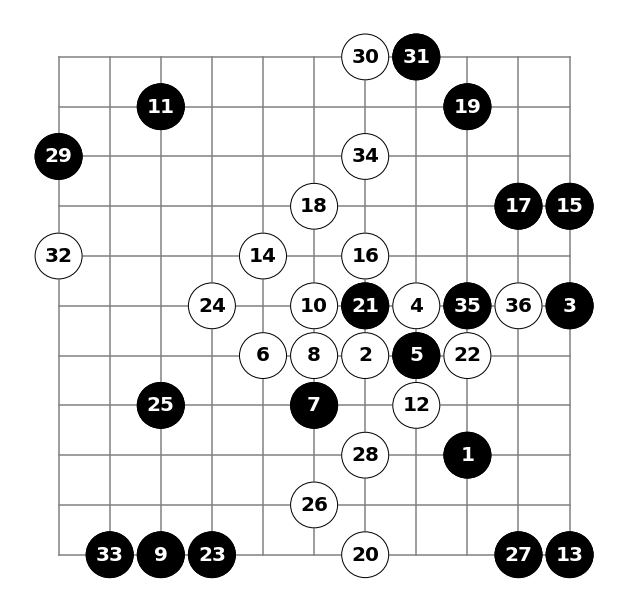

In [20]:
g = Mock5(H, W)
g.play(m5agent_random, agent_model,
       print_intermediate_state=False)
g.plot()
plt.show()
plt.close()

 [ Turn  10 ; 1P's turn (tone = O) ]
  | 0 1 2 3 4 5 6 7 8 9 A
--+----------------------
0 | . . . . . . . . . . .
1 | . . . . . . . . . . .
2 | . . . . . . . . . . .
3 | . . . . . O . . . . .
4 | . . . . . . O . . . .
5 | . . . O X X X X X . .
6 | . . . . . . O . . . .
7 | . . . . . . . O . . .
8 | . . . . . . . . . . .
9 | . . . . . . . . . . .
A | . . . . . . . . . . .
2p (agent-analysis-based) win!


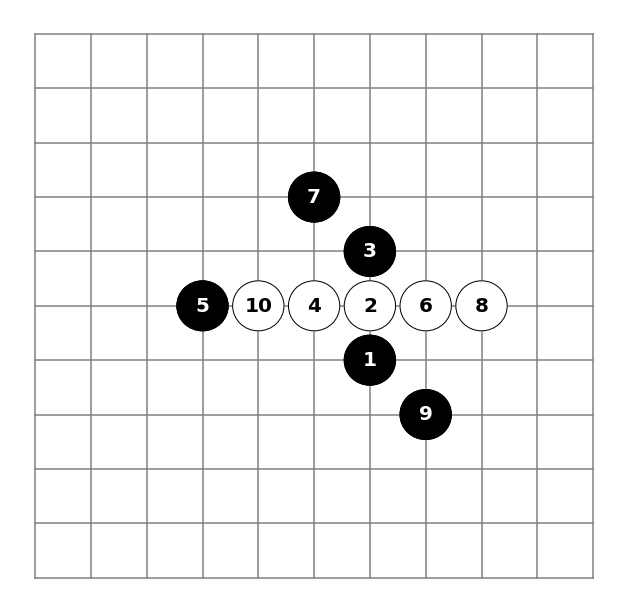

In [21]:
g = Mock5(H, W)
g.play(m5agent_a, agent_model,
       print_intermediate_state=False)
g.plot()
plt.show()
plt.close()

## 생각해볼 점

### Complexity

현재 직접 작성한 오목 알고리즘은 각 칸과 각 방향에
대해 돌이 나열된 배치를 보고 점수를 매기는
방식입니다.
이 때문에 각 칸에 대해 4개 방향에 대한 정보를
가지는 것이 최소한의 선이라고 보고,
그의 몇 배를 가지면 학습에 충분하지 않을까 생각을
했습니다.
다만, 실제로는 30개 정도의 feature를 입출력하는
CNN을 2층만 쌓는 경우는 수렴은 빠르지만 그
데이터를 제외하고는 제대로된 처리를 아예
하지 못하는 것을 볼 수 있습니다.
(이는 랜덤으로 돌을 두는 `agent_random`
과 게임을 진행시키면 승률 $80\%$를
넘기지도 못하는 것으로 확인할 수 있습니다.)

현재도 CNN을 3층으로 쌓아서 학습하고 있는데,
이 정도로도 특정 데이터셋이 아닌,
전체적으로 수렴해가는 모습을 보기는 힘듭니다.

그러면서도 CNN 3층으로도 수렴이 느린 것을 보면
층을 더 늘리게 되면 학습이 얼마나 더뎌질지 불 보듯
뻔합니다.

이 때문에 신경망 자체의 feature의 수나
층을 좀 더 다양하게 조절해볼 필요가 있어 보입니다.

### Batch Size

MCTS의 경우에는 한번 경험한 경로에 대한 정보를
모두 기록을 해나가는데, 이 때문에 크기가 너무
크다는 문제는 있지만, 정확하게 기보를 따라가며
값을 증가시키다보니, 값이 과하게 튀는 경우가
발생하기는 힘듭니다.

하지만 DNN의 경우는 말이 다른데, 여기서는
트리가 아니라 신경망의 parameter를 변화시키다보니
흔히 해당 기보 뿐만 아니라 다른 기보나 상태에 대한
출력에도 학습이 영향을 미치게 됩니다.

여기서 batch size에 대한 고민이 생기게 됩니다.
batch size가 너무 작으면 특정 데이터에 대한
loss를 줄이기 위해서 parameter가 바뀌어
나가게 되는데, 이 경우 과적합 하는 방향으로 학습될
가능성이 있으며, 애초에 모든 상태를 포함하는 데이터 공간이 너무 커서
아무리 batch size를 늘려도
이 데이터셋의 극미한 일부도 커버하지 못한다고
생각합니다.

결국에는 learning rate를 매우 낮춰서 학습용
batch의 영향을 줄이거나 batch size를 크게
잡거나 해야되는데, 어느 쪽이든 시간이나 데이터
수집과 관련한 문제가 생깁니다.

### Necessity of RL

제일 처음에 Q-Learning 같은 방식으로 학습을
진행했을 때는 exploration 후 그 결과를 바탕으로
신경망을 학습시키도록 하였습니다.
즉, 완전히 별개의 agent의 기보를 바탕으로 학습하는
것이 아닌, 자기 자신이 진행한 기보를 바탕으로
학습을 하였습니다.

이 방식으로만 학습을 하기에는 (Q-Learning의
정의역이 너무 큰 것도 있었지만)
자신이 직접 각 수에 대해 판단을 하는 과정이 필요해
시간 문제로 데이터를 많이 만들고 학습하기
힘들다는 문제가 있었습니다.
그래서 방향을 바꿔서 행동을 제외하고
상태에 대해서만 학습을 하되,
데이터는 다른 agent의 기보를 가져와서
그대로 학습하도록 한 것입니다.

이렇게 방향을 바꾸면서 문제 자체는 강화학습 대신에
비교적 단순한 심층학습으로 바뀌었고,
적어도 loss 자체가 감소한다든가
랜덤과 싸워서 이길 수 있을 정도는 되었습니다.

하지만 여전히 `agent_analysis_based`와
상대하게 되면 상대의 수를 한번도 막지 못하고
패합니다.

이 때문에 단순히 다른 agent끼리 둔 결과만을
반복적으로 보는 것보다는, 자신이 두는 방식으로
패했을 때 다음에는 그렇게 두지 않기 위한
오답노트가 필요한 것입니다.

다행히 제일 처음에 구현했던 신경망과 비교했을 때
현재는 이 오답노트를 적용하기가 비교적 쉽다고
봅니다.
우선 일단 기보만 완성된다면 굳이 각 수에 대해
$Q$ 값을 재계산할 필요 없이 승패여부만 알면 되며,
대칭을 계산하기 때문에 최소한의 수로 패배한다고
해도 $9 \times 16 = 144$ 개 정도의
데이터는 생겨납니다.
이 기보를 빠르게 생성하는 여전히 문제겠지만,
적어도 이전처럼 게임 하나 진행하는 것도 오래
걸릴 정도는 아니라는 것입니다.

이 방식은 Q-learning은 아니지만, 기보를
바탕으로 상태에 점수를 매겨서 각 상태에 대한
승률을 근사시켜 간다는 점에서 강화학습에 가깝다고
생각합니다.

이 다음에는 위에서 설명한 방식을 적용해보고자 합니다.
